# Logistic Regression

## Problem Statement

I decided to treat this as a classification problem by creating a new binary variable `affair` (did the woman have at least one affair?) and trying to predict the classification for each woman.

## Dataset

The dataset I chose is the [affairs dataset](http://statsmodels.sourceforge.net/stable/datasets/generated/fair.html) that comes with [Statsmodels](http://statsmodels.sourceforge.net/). It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a [1978 paper](http://fairmodel.econ.yale.edu/rayfair/pdf/1978a200.pdf) from the Journal of Political Economy.

## Description of Variables

The dataset contains 6366 observations of 9 variables:

* `rate_marriage`: woman's rating of her marriage (1 = very poor, 5 = very good)
* `age`: woman's age
* `yrs_married`: number of years married
* `children`: number of children
* `religious`: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
* `educ`: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
* `occupation`: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
* `occupation_husb`: husband's occupation (same coding as above)
* `affairs`: time spent in extra-marital affairs



In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

/home/skull/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First, let's load the dataset and add a binary affair column.

In [2]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

## Understanding Data

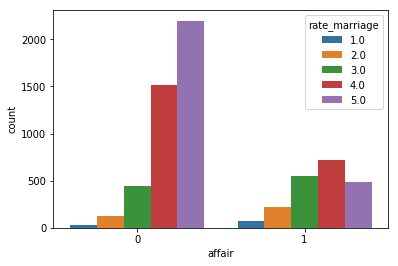

In [3]:
sns.countplot(dta["affair"],hue=dta["rate_marriage"])

Observation:We can see that on average, women who have affairs rate their marriages lower, which is to be expected.

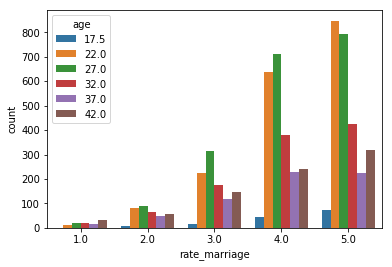

In [4]:
sns.countplot(dta["rate_marriage"],hue=dta["age"])

Observation:An increase in `age` appears to correlate with a declining marriage rating.

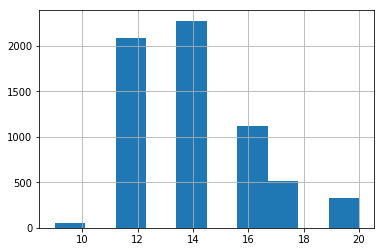

In [5]:
# histogram of education
dta["educ"].hist()

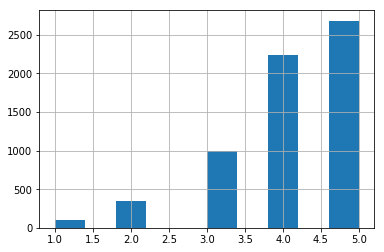

In [6]:
# histogram of marriage rating
dta.rate_marriage.hist()

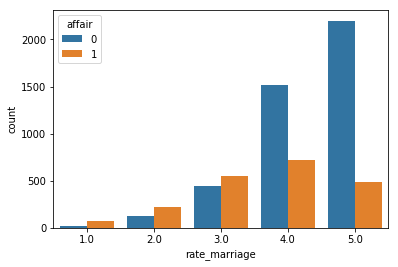

In [7]:
sns.countplot(dta.rate_marriage, hue=dta.affair)

Text(0,0.5,'Percentage')

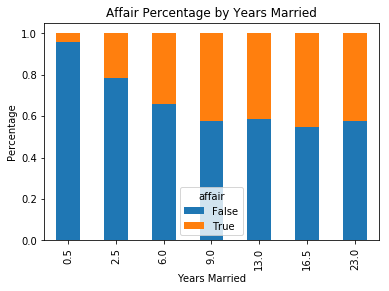

In [8]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

## Data cleansing

In [9]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [10]:
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [11]:
# flatten y into a 1-D array
y = np.ravel(y)
y

array([1., 1., 1., ..., 0., 0., 0.])

## Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is!


In [12]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7258875274897895

In [13]:
# what percentage had affairs?
y.mean()

0.3224945020420987

In [14]:
model.coef_

array([[ 1.49262352,  0.18804663,  0.49890692,  0.25095772,  0.8390479 ,
         0.83540972,  0.18807837,  0.29532785,  0.15893943,  0.18534772,
         0.1914224 , -0.7032632 , -0.05845574,  0.10570914,  0.01690639,
        -0.37120389,  0.00389819]])

## Model Evaluation Using a Validation Set

In [15]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print(predicted)

[1. 0. 0. ... 0. 0. 0.]


In [17]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print(probs)

[[0.3514255  0.6485745 ]
 [0.9095254  0.0904746 ]
 [0.72576645 0.27423355]
 ...
 [0.55736907 0.44263093]
 [0.81213878 0.18786122]
 [0.74729574 0.25270426]]


In [18]:
print(metrics.accuracy_score(y_test, predicted))

0.7298429319371728


In [19]:
print(metrics.confusion_matrix(y_test, predicted))
print(metrics.classification_report(y_test, predicted))

[[1169  134]
 [ 382  225]]
             precision    recall  f1-score   support

        0.0       0.75      0.90      0.82      1303
        1.0       0.63      0.37      0.47       607

avg / total       0.71      0.73      0.71      1910

